<a href="https://colab.research.google.com/github/gsheara/Image-Classification/blob/main/Classification_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

As both the accuracy of neural networks and their prominence in popular perception rapidly increase, many people may be familiar with interfacing with neural networks such as chatbots without even knowing it. Understanding the algorithms behind and how to conscruct a neural network model has many practical technological applications, one such being image classification.

The purpose of this notebook is to create an image classification algorithm for the CIFAR-10 dataset, which includes images of ten distinct animals and objects.

## Data
The first step is to import the data and the Python libraries used to work with it. This data was sourced from kaggle, but can be imported directly from the keras library.

In [ ]:
import glob
from PIL import Image
from io import BytesIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread

In [ ]:
import tensorflow as tf
from keras.datasets import cifar10

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

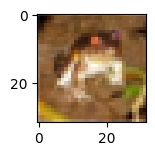

[6]


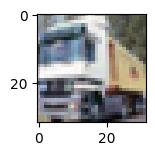

[9]


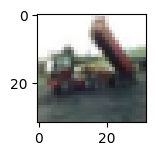

[9]


In [ ]:
for i in range(3):
  plt.subplot(330 + 1 + i)
  plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
  plt.show()
  print(y_train[i])

Next, the data must be reshaped to be a one-dimensional array and normalized.

In [ ]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

y_train = y_train.reshape(y_train.shape[0],)
y_test = y_test.reshape(y_test.shape[0],)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(50000, 3072)
(10000, 3072)
(50000,)
(10000,)


In [ ]:
X_train_norm = X_train / 255
X_test_norm = X_test / 255

##  Classification

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
                        fit_intercept=True,
                        multi_class='auto',
                        penalty='l2', #ridge regression
                        solver='saga',
                        max_iter=50,
                        C=50
                      )

In [ ]:
model.fit(X_train_norm, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=50, max_iter=50, solver='saga')

In [ ]:
y_pred = model.predict(X_test_norm)
accuracy = sum(y_pred == y_test) / len(y_test)
print(accuracy)

0.4084


I was surprised by how low the model's accuracy was, being under even 50%. I had initially set the max iterations to 100, but after 30 minutes of runtime I set it to 10 instead. When this produced an accuracy of only about 41%, I hoped that setting the iterations higher again would increase accuracy, but it stayed the same. My theory is that logistic regression classifies data into two categories, but in this dataset I'm working with all ten classes.

## Building the Neural Network Model

In [ ]:
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.4 MB/s eta 0:00:00


In [ ]:
import keras
import keras_tuner
from keras import layers, regularizers
from keras.optimizers.legacy import Adam
from keras.callbacks import EarlyStopping, TensorBoard

Initializing the model, we use 10 layers for the 10 classes in the dataset.

In [ ]:
def define_model(units, num_layers, activation, lr, l2):
    model_layers = [
        layers.Dense(units, activation=activation, kernel_regularizer=regularizers.L2(l2=l2), kernel_initializer=keras.initializers.HeNormal())
        ] * num_layers
    model_layers += [layers.Dense(10)]
    model = keras.Sequential(model_layers)
    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'], optimizer=Adam(learning_rate=lr))

    return model

def build_model(hp):
    units = hp.Choice("units", [256, 512])
    activation = "relu"
    lr = hp.Float("lr", min_value=1e-5, max_value=1e-1, sampling="log")
    l2 = hp.Float("l2", min_value=1e-5, max_value=1e-1, sampling="log")
    num_layers = hp.Choice("num_layers", [2, 3, 4])

    model = define_model(units=units, num_layers=num_layers, activation=activation, lr=lr, l2=l2)
    return model

In [ ]:
tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=8,
    executions_per_trial=1,
    overwrite=False,
    directory="/content/drive/MyDrive",
)

Reloading Tuner from /content/drive/MyDrive/untitled_project/tuner0.json


In [ ]:
callbacks = [EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True, start_from_epoch=4)]

The model uses the preferences set above to go through iterations of the data. As the epochs progressed, my loss and value loss got lower, but the accuracy stayed pretty low around 40%.

In [ ]:
tuner.search(
    X_train_norm,
    y_train,
    epochs=8,
    verbose=1,
    validation_data=(X_test_norm, y_test),
    callbacks=callbacks
)

Trial 8 Complete [00h 04m 31s]
val_loss: 1.7280992269515991

Best val_loss So Far: 1.474564552307129
Total elapsed time: 00h 41m 05s


In [ ]:
tuner.results_summary(5)

Results summary
Results in /content/drive/MyDrive/untitled_project
Showing 5 best trials
Objective(name="val_loss", direction="min")

Trial 5 summary
Hyperparameters:
units: 512
lr: 0.0001924959852667065
l2: 1.9446879330730795e-05
num_layers: 2
Score: 1.474564552307129

Trial 4 summary
Hyperparameters:
units: 512
lr: 7.519372028890168e-05
l2: 9.299673514734171e-05
num_layers: 3
Score: 1.5198427438735962

Trial 6 summary
Hyperparameters:
units: 256
lr: 0.0009047688303690656
l2: 0.0022948318644627308
num_layers: 3
Score: 1.7218623161315918

Trial 7 summary
Hyperparameters:
units: 512
lr: 0.0028003630371896244
l2: 2.1001473421860966e-05
num_layers: 3
Score: 1.7280992269515991

Trial 00 summary
Hyperparameters:
units: 512
lr: 0.00029614330636395847
l2: 0.008876762094159406
num_layers: 2
Score: 1.7806267738342285


Overall based on these iterations, the model did not perform exceptionally well at classifying the different images. This could possibly be due to a mishandling of the high number of classes in the dataset. It could be more beneificial to hone in on a particular pair of images, such as airplanes and birds, and train the neural network to differentiate between those two rather than trying to parce all 10 together.

Finally, a confusion matrix will be used to evaluate the results.

In [ ]:
import json
from sklearn.metrics import confusion_matrix

trial_num = "5"
with open(f"/content/drive/MyDrive/untitled_project/trial_{trial_num}/trial.json", "r") as f:
    trial = json.load(f)
hp = trial["hyperparameters"]["values"]
model = define_model(units=hp["units"], num_layers=hp["num_layers"], activation="relu", lr=hp["lr"],
                     l2=hp["l2"])
model.load_weights(f"/content/drive/MyDrive/untitled_project/trial_{trial_num}/checkpoint")

In [ ]:
import numpy as np
y_pred = np.argmax(model.predict(X_test_norm), axis=1)
cm = confusion_matrix(y_test, y_pred)
accuracy = sum(y_pred == y_test) / len(y_test)
print(accuracy)
print(cm)

313/313 [==============================] - 5s 15ms/step
0.4824
[[760  21  39  10   4  17  28  14  69  38]
 [ 98 599  11  13   5  22  13  15  65 159]
 [186  32 368  43  48  87 136  50  22  28]
 [101  23  87 219  18 242 169  40  26  75]
 [153  16 180  29 245  74 192  73  20  18]
 [ 83  19 120 116  19 408 115  57  26  37]
 [ 42  19  81  34  47  70 640  23  20  24]
 [122  17  67  44  44  81  64 478  15  68]
 [259  61  11  22   4  18  12   8 542  63]
 [112 154  10  18   5  26  35  26  49 565]]


A heatmap is used as a quick visualization tool of the data.

<Axes: >

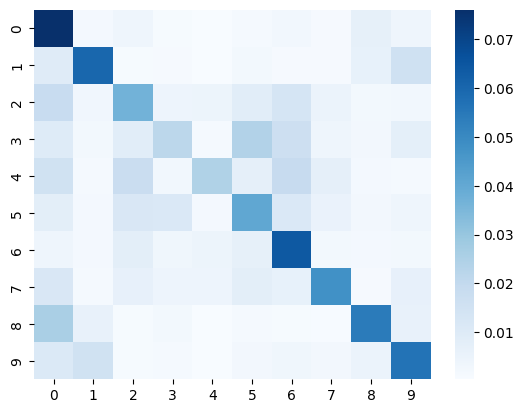

In [ ]:
import seaborn as sns
sns.heatmap(cm/np.sum(cm), annot=False,
            cmap='Blues')

By observing this confusion matrix, we can see higher values across the diagonal of the heatmap, which represent the True or accurately predicted values.

## Conclusion

Overall, both the neural network and logistic regression struggled to classfy all ten classes of images with more than 50% accuracy. While this is a disappointingly low percentage, it is however significantly more accurate than random guessing or about 1 in 10 accuracy.